In [2]:
# These libaries will be doing the bulk of the heavy lifting!
import numpy as np
import pandas as pd
import sympy as sp
from scipy import linalg

# these models contain all of the code
import ramsey
import pwt

# matplotlib is for graphics, seaborn for nice graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# fix division as prevention from typos
from __future__ import division

%load_ext autoreload
%autoreload 2

# Playing with the Ramsey Model

This is something called an ipython notebook, a cool feature of a programming language called python.

A few years ago, when Msc students used to have macro labs, [David Pugh](https://github.com/davidrpugh) wrote some code to create, solve and analyse a Ramsey model.

Some notes before we proceed:

* The production function is CES:

$$f(k(t)) = \bigg[\alpha k(t)^\gamma + (1 - \alpha)\bigg]^{\frac{1}{\gamma}} $$

Where $0 < \alpha < 1$ and $-\infty < \gamma < 1$. The parameter $\gamma = \frac{\sigma - 1}{\sigma}$ where $\sigma$ is the elasticity of substitution between capital and effective labor.

* The Utility function is CRRA:

$$u(c) = \frac{c^{1 - \theta} - 1}{1 - \theta} $$

* So the system of equations from question one is:

\begin{align}
 	\dot{k} =& f(k(t)) - (n+g+\delta)k(t) - c(t),\ k(0) = k_0 \\
	\dot{c} =& \left[\frac{f'(k(t)) - \delta - \rho - \theta g}{\theta}\right]c(t),\ 0 < \lim_{t\rightarrow\infty} |c(t)| < \infty 
\end{align}

And we are ready to go!

## Setting the model

This is going to look like black magic to you (for now) but the next "cell" is asking the computer to run a python file that sets the model described above with default parameters. We don't need to talk too much about those because...

In [3]:
%run -i preset.py

... we are calibrating out economy using real world data from the [Penn World Tables (PWT)](http://www.rug.nl/research/ggdc/data/penn-world-table)!

You have just seen how calibration works, and the main idea behind what I'm going to show you is the same: given some aggregates of an economy, the function `ramsey.calibrate` is going to set the parameters of the model to match (as close as possible) the data for the UK.

For more details on how this is done, I'm going to refer you to [the original lab](https://github.com/davidrpugh/numerical-methods/blob/master/labs/lab-2/lab-2.ipynb), section 2. You can open it with any internet browser (even in Internet Explorer!).

In [29]:
ramsey.calibrate_ces(model,                                          # Base model (defined in preset.py)
                     iso3_code='GBR',                                # Country code
                     bounds=[1950, 2011],                            # Years to use
                     sigma0=0.5, alpha0=0.5, theta0=2.5, rho=0.04)   # Initial guesses

Total sum of squares: 1372.10637276
Sucessful estimation of sigma and alpha: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
Calibration of theta successful! The solution converged.


What are the steady-state values?

In [30]:
model.steady_state.values

{'c_star': 1.3166288898985368, 'k_star': 3.4396353541410534}

## Playing with shocks

First let's take a look at the old fashined phase diagram for the calibrated model.

`model` has a function called `plot_phase_diagram` that does just that for us.

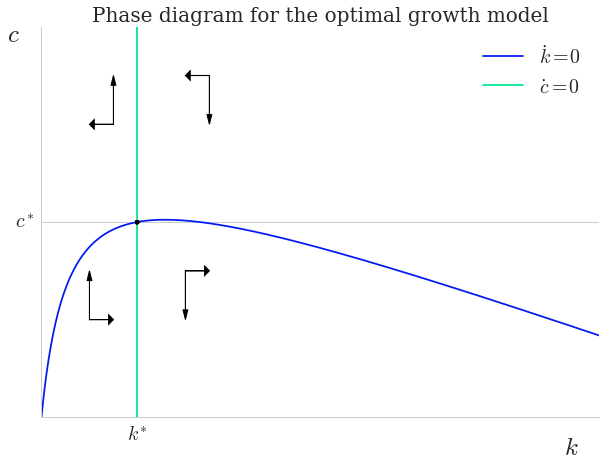

In [31]:
plt.figure(figsize=(10,7))
model.plot_phase_diagram(gridmax=20, N=1000, arrows=True)
plt.show()

**How about a shock?**

The equations here for convenience:

\begin{align}
 	\dot{k} =& f(k(t)) - (n+g+\delta)k(t) - c(t),\ k(0) = k_0 \\
	\dot{c} =& \left[\frac{f'(k(t)) - \delta - \rho - \theta g}{\theta}\right]c(t),\ 0 < \lim_{t\rightarrow\infty} |c(t)| < \infty 
\end{align}


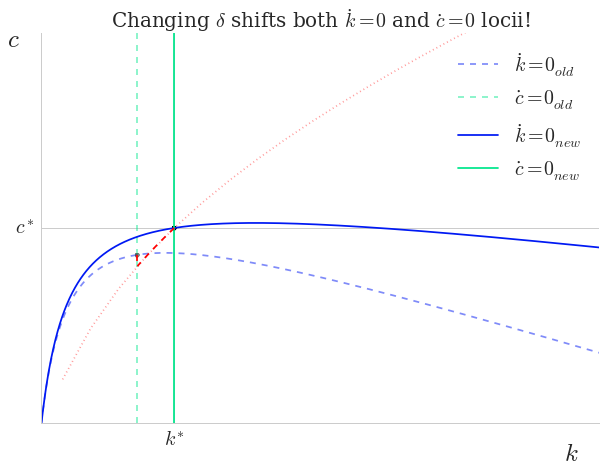

In [60]:
plt.figure(figsize=(10,7))
model.plot_phase_diagram(gridmax=20, N=1000, arrows=False, param='delta', shock=0.004, reset=True, plot_traj=True, plot_manif=True)
plt.show()

But our little model can do even more! Let's se the steps one by one by creating a movie!

The `plot_movie` function does that for us:

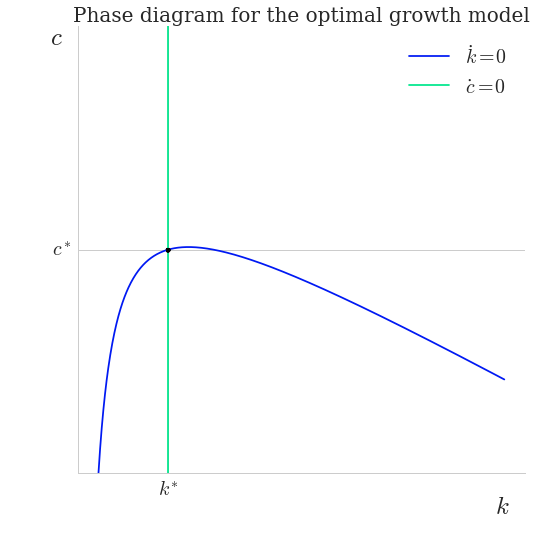

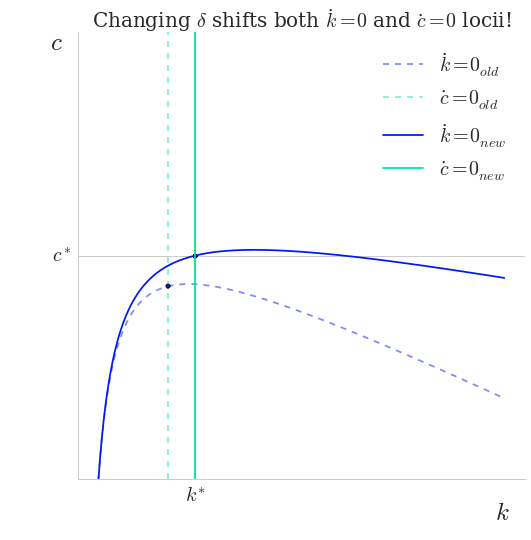

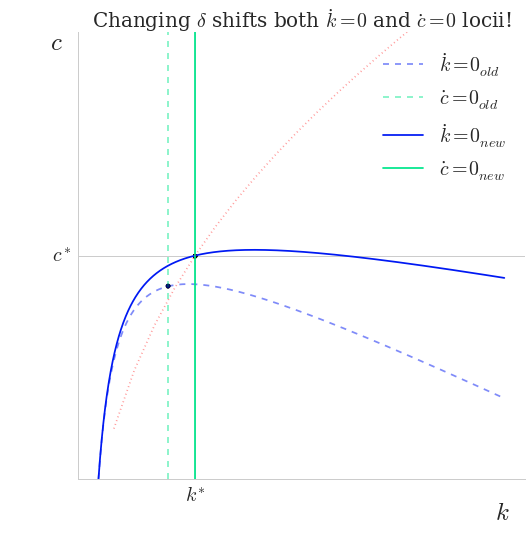

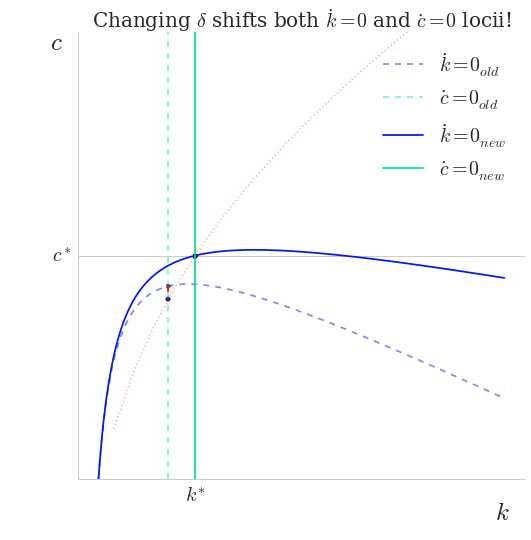

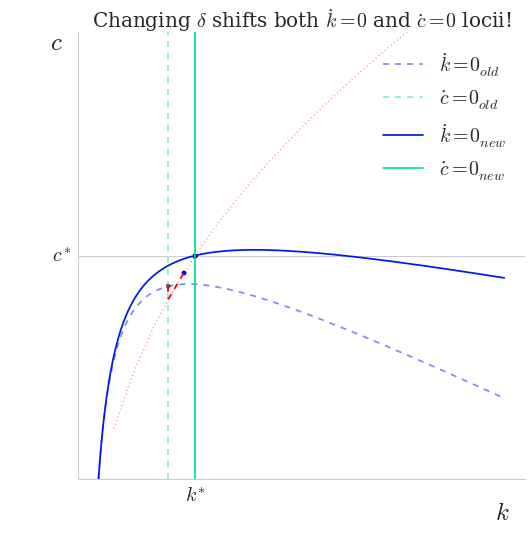

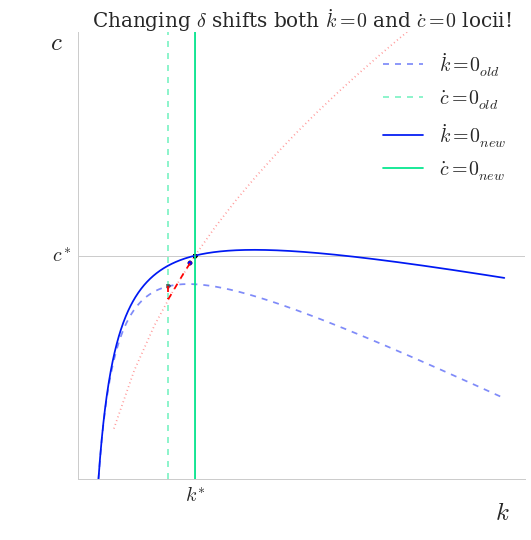

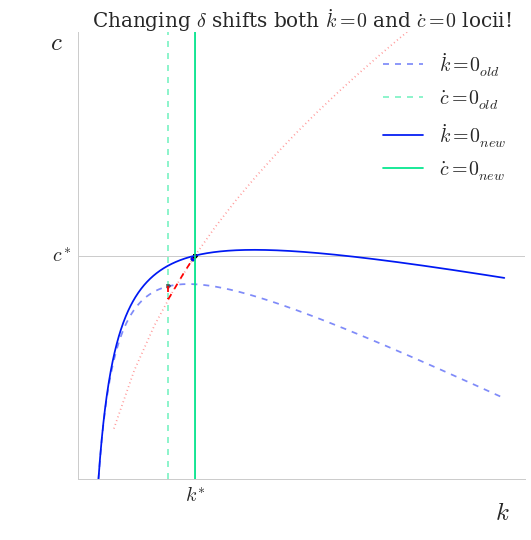

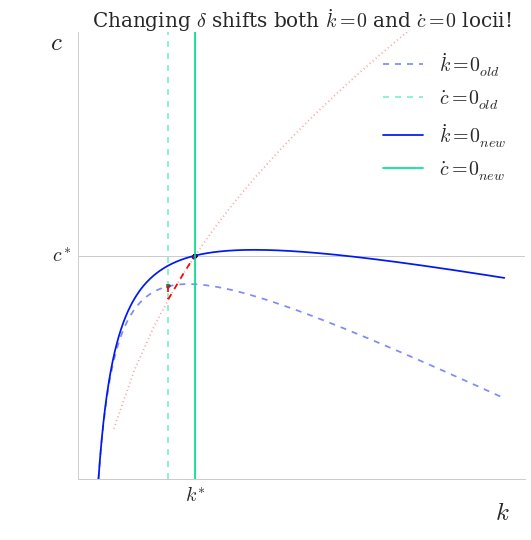

In [39]:
model.plot_movie(gridmax=20, pam='delta', pamshock=0.004,tmax=200, t_step=50,formatt='mp4')

In [40]:
%%HTML
<video width="320" height="240" controls>
  <source src="pam_shock.mp4" type="video/mp4">
</video>

# Shooting for the moon

But this not not exactly what Jan asked you to do.

He wants you to start from an arbitrary point in the diagram and then using the laws of motion for $\dot(c)$ and $\dot(k)$ to see if you can converge to the steady state.

The answer is that you can't, unless you match the perfect $\gamma$ fraction of consumption for a given $\kappa$ fraction of capital as you starting point.

To illustrate this, you can use the answer spreadsheet in excell with different values for $gamma$.

Or we can play aorunf our plot, see if we can all 'shoot for the steasy state'!

The mechanism is the same: starting in $k_0,c_0$ we use the laws of motin of $k$ and $c$ to update. The code below does this in continuous time (thus the `model.integrate`)

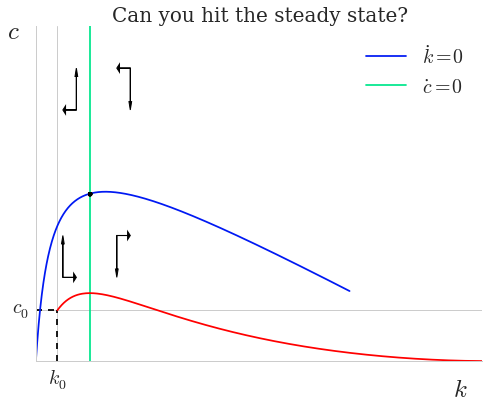

In [44]:
plt.figure(figsize=(8,6))

# plot the phase diagram
model.plot_phase_diagram(gridmax=20, N=1000, arrows=True)

# you need to modify c0 and T to try and "hit" the steady state!
k0 = 0.4 * model.steady_state.values['k_star']
c0 = 0.4
T  = 100
# Calculate trajectory
traj = model.integrate(t0=0, y0=[k0, c0], h=0.1, T=T, integrator='dopri5')

# plot the trajectory 
model.plot_trajectory(traj, color='r')

# demarcate the initial condition
plt.vlines(k0, 0, c0, linestyle='dashed', color='k')
plt.xticks([k0], ['$k_0$'])
plt.hlines(c0, 0, k0, linestyle='dashed', color='k')
plt.yticks([c0], ['$c_0$'])

# change the plot title
plt.title('Can you hit the steady state?', fontsize=20, family='serif')
plt.show()

More generally, it is very difficult to get to the steady state, as there is only a unique path that converges to the steady-state, and starting from the wrong point leads you very far away from were you started.

Starting from below...

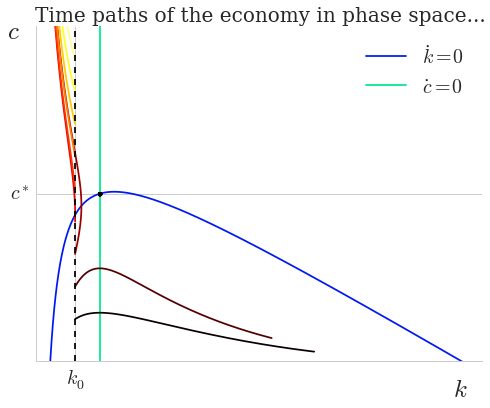

In [45]:
plt.figure(figsize=(8,6))

# plot the phase diagram
model.plot_phase_diagram(gridmax=30, N=1000, arrows=False)

# new initial condition for k
k0 = model.steady_state.values['k_star'] / 2

# set of initial conditions for c
N = 10
c_lower   = model.steady_state.values['c_star'] / 4
c_upper   = 2 * model.steady_state.values['c_star']
init_vals = np.linspace(c_lower, c_upper, N)

# color scheme
color_map = mpl.cm.hot(np.linspace(0, 1, N))

for i, c0 in enumerate(init_vals):
    
    # simulate the model
    traj = model.integrate(t0=0, y0=[k0, c0], h=0.1, T=20, integrator='lsoda')

    # plot the trajectory 
    model.plot_trajectory(traj, color=color_map[i])

# demarcate the initial condition
plt.axvline(k0, linestyle='dashed', color='k')
plt.xticks([k0], ['$k_0$'])

# change the plot title
plt.title('Time paths of the economy in phase space...', fontsize=20, family='serif')
plt.show()

And from above...

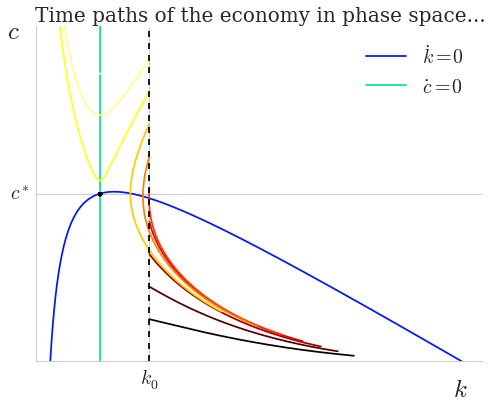

In [46]:
plt.figure(figsize=(8,6))

# plot the phase diagram
model.plot_phase_diagram(gridmax=30, N=1000, arrows=False)

# new initial condition for k
k0 = 2 * model.steady_state.values['k_star']

# set of initial conditions for c
N = 10
c_lower   = model.steady_state.values['c_star'] / 4
c_upper   = 2 * model.steady_state.values['c_star']
init_vals = np.linspace(c_lower, c_upper, N)

# color scheme
color_map = mpl.cm.hot(np.linspace(0, 1, N))

for i, c0 in enumerate(init_vals):
    
    # simulate the model
    traj = model.integrate(t0=0, y0=[k0, c0], h=0.1, T=20, integrator='lsoda')

    # plot the trajectory 
    model.plot_trajectory(traj, color=color_map[i])

# demarcate the initial condition
plt.axvline(k0, linestyle='dashed', color='k')
plt.xticks([k0], ['$k_0$'])

# change the plot title
plt.title('Time paths of the economy in phase space...', fontsize=20, family='serif')
plt.show()

How do we solve for the saddle path then?

There are two answers: Linearization and Computational methods.

- Linarization works well aroudn the steady state.

- Shooting does what we did above, but keeps on searching until it find the optimum.

Perfoming the same repetitive task over an over again is what computers do best.

## Linearization - bear with me!

To construct a linear approximation of the optimal growth model, begin by noting that time enters only indirectly into the analysis. Thus we can write

$$\dot{k}(t) = \dot{k}(k, c) \\ \dot{c}(t) = \dot{c}(k, c)$$  

We now wish to approximate this system of equations using a first-order Taylor expansion around the long-run equilibrium point $(k^*, c^*)$.

\begin{align}
\dot{k}(k, c) \approx& \dot{k}(k^*, c^*) + \frac{\partial \dot{k}}{\partial k}\bigg|_{k=k^*, c=c^*}(k - k^*) +  \frac{\partial \dot{k}}{\partial c}\bigg|_{k=k^*, c=c^*}(c - c^*)  \\
\dot{c}(k, c) \approx& \dot{c}(k^*, c^*) + \frac{\partial \dot{c}}{\partial k}\bigg|_{k=k^*, c=c^*}(k - k^*) +  \frac{\partial \dot{c}}{\partial c}\bigg|_{k=k^*, c=c^*}(c - c^*) 
\end{align}

Note that $\dot{k}(k^*, c^*) = \dot{c}(k^*, c^*) =0$, and define the following change of variables.

$$\tilde{k}(t) = k(t) - k^* \\ \tilde{c}(t) = c(t) - c^*$$ 

These definitions imply that  $\dot{\tilde{k}}(t) = \dot{k}(t)$ and $\dot{\tilde{c}}(t) = \dot{c}(t)$. Using this change of variables we can re-write the original non-linear system as follows.

\begin{align}
\begin{bmatrix}
	\dot{\tilde{k}}(t) \\  
	\dot{\tilde{c}}(t)
\end{bmatrix}
=&
\begin{bmatrix}
	\frac{\partial \dot{k}}{\partial k} & \frac{\partial \dot{k}}{\partial c} \\
	\frac{\partial \dot{c}}{\partial k} & \frac{\partial \dot{c}}{\partial c} \\
\end{bmatrix}
\Bigg|_{k=k^*, c=c^*}
\begin{bmatrix}
	\tilde{k}(t) \\
	\tilde{c}(t)
\end{bmatrix} \tag{4.2.1} \\
\tilde{k}(0) =& k_0 - k^* \tag{4.2.2}\\
\lim_{t\rightarrow\infty} |\tilde{c}(t)| =& 0 \tag{4.2.3}
\end{align}

where $\tilde{k}(t)$ is the pre-determined (i.e., state) variable and $\tilde{c}(t)$ is a free (i.e., control) variable. Note that we have transformed our original non-linear boundary value problem into a linear boundary value problem with constant coefficients which, assuming certain determinacy conditions are satisfied, can be solved explicitly.

The next step in the linearization is to compute the Jacobian matrix of partial derivatives and evaluate it at the long-run equilibrium. 

\begin{align}
\mathcal{J}\big|_{k=k^*, c=c^*}=& 
\begin{bmatrix}
	\frac{\partial \dot{k}}{\partial k} & \frac{\partial \dot{k}}{\partial c} \\
	\frac{\partial \dot{c}}{\partial k} & \frac{\partial \dot{c}}{\partial c} \\
\end{bmatrix}
\Bigg|_{k=k^*, c=c^*}
=
\begin{bmatrix}
	f'(k^*) - (n + g + \delta) & -1 \\
	\frac{c^*}{\theta}f''(k^*) & \frac{f'(k^*) - \delta - \rho - \theta g}{\theta} 
\end{bmatrix}
=
\begin{bmatrix}
	\beta & -1 \\
	\frac{c^*}{\theta}f''(k^*) & 0
\end{bmatrix}
\end{align}

where $\beta = f'(k^*) - (n + g + \delta)$. Substituting this result into 4.2.1 yields:

\begin{align}
\begin{bmatrix}
	\dot{\tilde{k}}(t) \\  
	\dot{\tilde{c}}(t)
\end{bmatrix}
=&
\mathcal{J}\big|_{k=k^*, c=c^*}
\begin{bmatrix}
	\tilde{k}(t) \\
	\tilde{c}(t)
\end{bmatrix} \tag{4.2.4} \\
\tilde{k}(0) =& k_0 - k^* \\
\lim_{t\rightarrow\infty} |\tilde{c}(t)| =& 0
\end{align}

Now we need to solve this system. To solve linear systems of differential equations with constant coefficients we need to diagonalize the matrix $\mathcal{J}$ by decomposing it into the product of two special matrices 

$$ P = \begin{bmatrix}P_{00} & P_{01} \\ P_{10} & P_{11} \\ \end{bmatrix},\ \Lambda=\begin{bmatrix}\lambda_{0} & 0 \\ 0 & \lambda_1 \\ \end{bmatrix} \tag{4.2.5}$$ 

such that 

\begin{equation}
\mathcal{J}\big|_{k=k^*, c=c^*} = P^{-1}\Lambda P \tag{4.2.6}
\end{equation} 

where the matrix $\Lambda$ is a diagonal matrix of whose entries are the eigenvalues of $\mathcal{J}$ and the rows of the matrix $P$ are the normalized left-eigenvectors of $\mathcal{J}$.  

In [47]:
# store the model's steady state values as a list
steady_state        = [model.steady_state.values['k_star'], model.steady_state.values['c_star']]

# evaluate the jacobian of the system at the models steady state 
evaluated_jacobian  = ramsey_jacobian(0, steady_state, model.params)

# display the result
print evaluated_jacobian

[[  3.37635544e-02  -1.00000000e+00]
 [ -6.79123556e-02  -2.08166817e-16]]


In [48]:
# linalg.eig returns a tuple of the form (values, vectors)
eig_vals, eig_vecs = linalg.eig(evaluated_jacobian, left=True, right=False)

# create the diagonal matrix Lambda using the eigenvalues
Lambda = np.diag(eig_vals)

# create the matrix P where rows are eigenvectors!
P      = eig_vecs.T

# compute P^-1
P_inverse = linalg.inv(P)

# To check the decomposition is correct, compare this result...
print P_inverse.dot(Lambda).dot(P)

[[  3.37635544e-02+0.j  -1.00000000e+00+0.j]
 [ -6.79123556e-02+0.j  -1.94289029e-16+0.j]]


In [49]:
# ...with this one!
print evaluated_jacobian

[[  3.37635544e-02  -1.00000000e+00]
 [ -6.79123556e-02  -2.08166817e-16]]


Almost perfect!

In general, systems of linear equations can have zero, one, or an infinite number of solutions. We want 4.2.5 to have a unique solution. In order for the system to have a unique solution, we need...

1. Number of eigenvalues with *negative* real parts (i.e., stable eigenvalues) equals the number of pre-determined variables;
2. Number of eigenvalues with *positive* real parts (i.e., unstable eigenvalues) equals the number of free or control variables. 

The optimal growth model has one pre-determined variable (i.e., capital per effective worker) and one free or control variable (i.e., consumption per effective worker). Thus in order for the model to have a unique solution we need one eigenvalue with negative real part and one eigenvalue with positive real part.

Let's check the eigenvalues to make sure that we have a unique solution!

In [50]:
eig_vals

array([ 0.27802800+0.j, -0.24426445+0.j])

Good news! From here I'm going to leave it and tell you that once you have $P$ and $\Lambda$ you can solve 4.2.6 (solving a system of differential equations) and find the saddle path ($c(k)$).

More good news is that the computer can do this for you. You just need to give the function `model.solve_linearization` an initial guess and it will approximate the saddle path.

This means we have to give it a guess above and below the stady-state:

In [51]:
# specify an initial condition and a set of time points - above st-st
k0 = 3 * model.steady_state.values['k_star']
t  = np.linspace(0, 100, 10)

# generate a linearized approximation to the lower branch of the stable manifold
ms_upper_linear = model.solve_linearization(k0, t)

# specify an initial condition and a set of time points - below st-st
k0 = model.steady_state.values['k_star'] / 4
t  = np.linspace(0, 100, 10)

# generate a linearized approximation to the lower branch of the stable manifold
ms_lower_linear = model.solve_linearization(k0, t)

Plot the result:

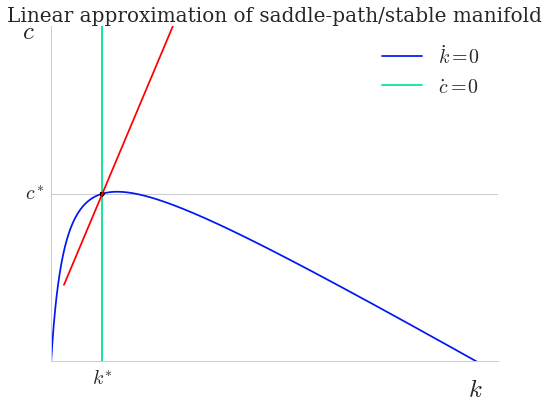

In [52]:
plt.figure(figsize=(8,6))

# plot a phase diagram
model.plot_phase_diagram(30)

# plot the lower half of the linearized stable manifold
model.plot_trajectory(ms_lower_linear, color='r')

# plot the lower half of the linearized stable manifold
model.plot_trajectory(ms_upper_linear, color='r')

# change the title
plt.title('Linear approximation of saddle-path/stable manifold', fontsize=20, family='serif')
plt.show()

## Shooting

The shooting algorithm is very easy: start with an initial guess, and if the we start getting far away from the steady-state, we missed it and we have to guess again.

We can be clever and adjust the guesses depending on whether we overshoot (consumption goes to $\inf$) or undershoot (consumption goes to 0):

     # Bracket the true c(0) by setting cL=0 and cH = y + (1 - delta)k. 
    cL = 0
    cH = f(k0) + (1 - delta) * k0
    
    # Guess that c0 = 0.5(cH + cL) and specify a stopping tolerance, tol > 0.
    c0 = 0.5 * (cH + cL)
    
    while True:
        Solve the model as an IVP with k(0)=k0 and c(0)=c0
        if c is falling:
            # check for convergence
            if |c(T) - c^*| < tol:
                break
            # current guess too low!
            else:
                cL = c0 
                c0 = 0.5 * (c_H + c_L)
	
        elif k is falling:
            # check for convergence
            if |c(T) - c^*| < tol:
                break   
            # current guess too high!
            else: 
                cH = c0
                c0 = 0.5 * (cH + cL)
                
Let's see it in action!

In [53]:
# set initial condition for capital per effective worker
k0 = model.steady_state.values['k_star'] / 4

# compute the lower branch of the stable manifold using forward shooting
ms_lower = model.solve_forward_shooting(k0, h=1.0, tol=1.5e-4, mesg=True, integrator='dopri5')

Old c0 too high, new c0 = 0.216614391016
Old c0 too low, new c0 = 0.324921586524
Old c0 too low, new c0 = 0.379075184278
Old c0 too low, new c0 = 0.406151983155
Old c0 too high, new c0 = 0.392613583717
Old c0 too low, new c0 = 0.399382783436
Old c0 too low, new c0 = 0.402767383296
Old c0 too high, new c0 = 0.401075083366
Old c0 too low, new c0 = 0.401921233331
Old c0 too low, new c0 = 0.402344308313
Old c0 too high, new c0 = 0.402132770822
Old c0 too low, new c0 = 0.402238539568
Old c0 too low, new c0 = 0.402291423941
Old c0 too low, new c0 = 0.402317866127
Old c0 too high, new c0 = 0.402304645034
Old c0 too low, new c0 = 0.40231125558
Old c0 too high, new c0 = 0.402307950307
Old c0 too low, new c0 = 0.402309602944


That was fast! Let's try with a value of $k$ above steady state:

In [54]:
# set initial condition for capital per effective worker
k0 = 3 * model.steady_state.values['k_star']

# compute the upper branch of the stable manifold using forward shooting
ms_upper = model.solve_forward_shooting(k0, h=1.0, tol=1e-6, mesg=False, integrator='dopri5')


Done!

How does this compare to linearization?

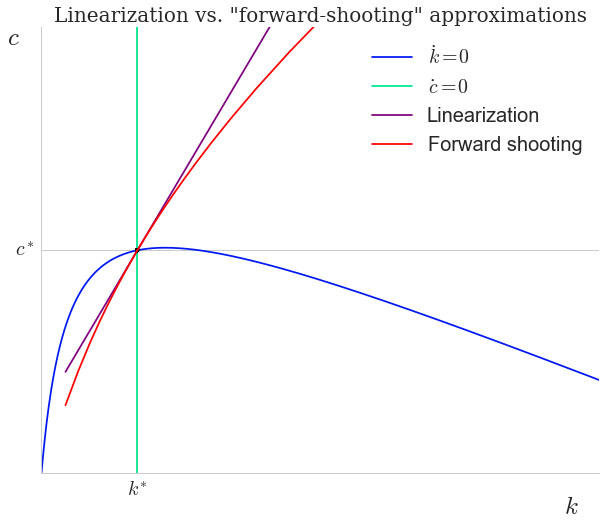

In [55]:
plt.figure(figsize=(10,8))

# plot the phase diagram
model.plot_phase_diagram(gridmax=20, N=1000, arrows=False)

# forward shooting approximation of stable manifold
model.plot_trajectory(ms_upper_linear, color='purple')
model.plot_trajectory(ms_lower_linear, color='purple', label='Linearization')

# forward shooting approximation of stable manifold
model.plot_trajectory(ms_upper, color='r')
model.plot_trajectory(ms_lower, color='r', label='Forward shooting')

# change the plot title
plt.title('Linearization vs. "forward-shooting" approximations', fontsize=20, family='serif')
plt.legend(loc=0, frameon=False, fontsize=20)
plt.show()

So all in all, linearization is and ok approximation when close to the steady state.

# Take outs from this exercise

### 1. Linearization is a useful tool for macroeconomists, but one has to use it with care.

### 2. In general, computers have render linearization obsolete, yet it is useful for checking the stability conditions.

### 3. The equilibrium of the neoclassical model depends crutially on $c_t$ being able to jump instantaneously.

### 4. Computers make our life easier!

If you want to learn more, I am going to run a extra-curricular course called "The Code Club", that will teach you the wonders of computers for economists - starting from 0. 

Go to [the course website](https://sites.google.com/site/sgpecodeclub/) for more information and sign up.


## Oh, I forgot about impulse responses...

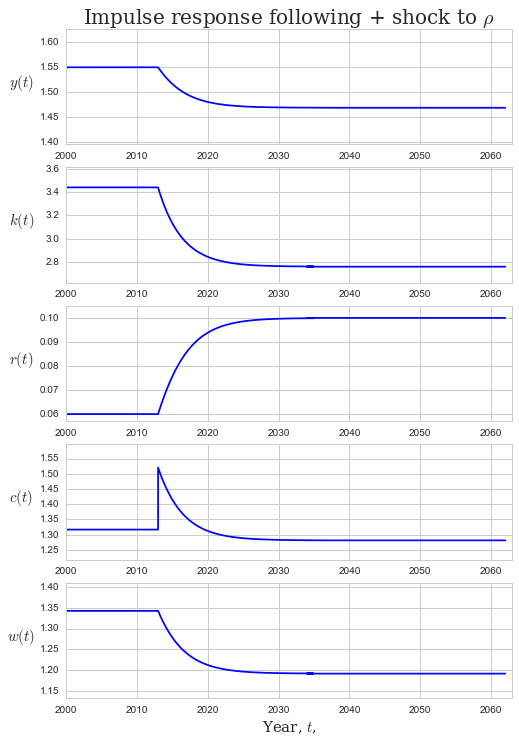

In [56]:
model.plot_impulse_response(variables='all', method='forward_shooting', kind='efficiency_units',
                            param='rho', shock=2.0, T=50, figsize=(8,12), log=False)
plt.show()

There you go!